<p style="font-size: 30px;">Importing Required Libraries</p>


In [4]:
from tqdm import tqdm
from random import randint
import numpy as np
import nibabel as nib
import nilearn.plotting as nlplt
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import seaborn as sns
import glob
import tensorflow as tf
to_categorical = tf.keras.utils.to_categorical
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

<p style="font-size: 25px;">Loading Sample File from BraTS 2020</p>

In [3]:
#load --> conversion to array --> rotate 90 

sample_filename = r"C:\Users\abul4\OneDrive\Desktop\Project\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_flair.nii"
sample_filename_mask = r"C:\Users\abul4\OneDrive\Desktop\Project\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_seg.nii"

sample_img = nib.load(sample_filename)
sample_img = np.asanyarray(sample_img.dataobj)  #converts to array
sample_img = np.rot90(sample_img)               #rotate 90degrees


sample_mask = nib.load(sample_filename_mask)
sample_mask = np.asanyarray(sample_mask.dataobj)
sample_mask = np.rot90(sample_mask)

print("img shape ->", sample_img.shape)
print("mask shape ->", sample_mask.shape)

img shape -> (240, 240, 155)
mask shape -> (240, 240, 155)


PART 1: 

Includes, dividing each image by its max to scale them to [0,1]

Converting mask from float to uint8

Changing mask pixel values (labels) from 4 to 3 (as the original labels are 0, 1, 2, 4)

Combining all 4 images to 4 channels of a numpy array.

Visualize

[0 1 2 4]
[0 1 2 3]


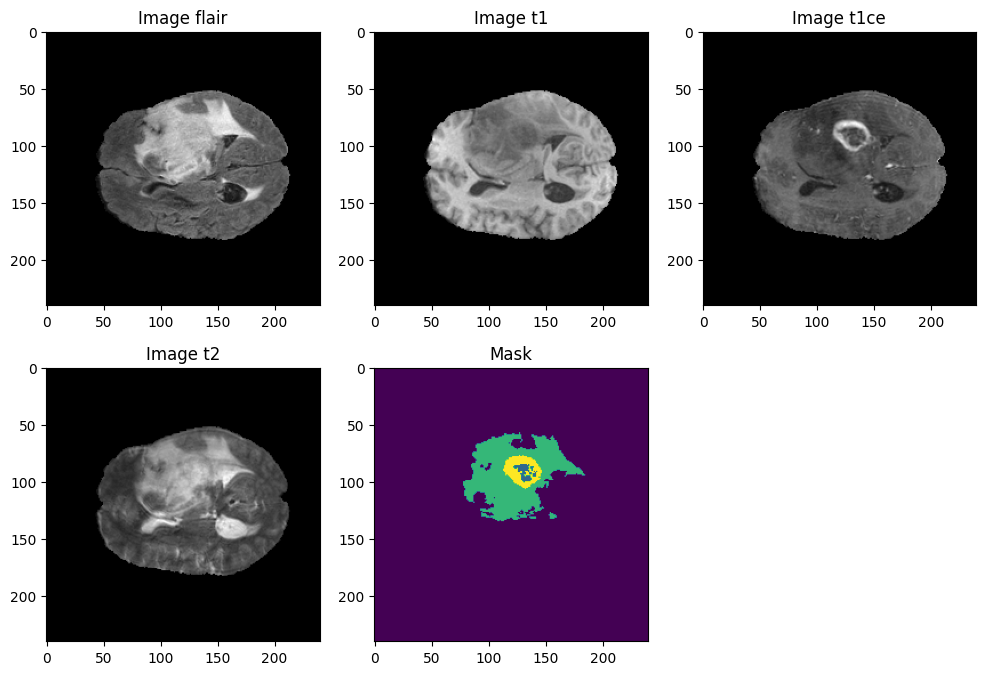

In [5]:
TRAIN_DATASET_PATH = r'C:\Users\abul4\OneDrive\Desktop\Project\MICCAI_BraTS2020_TrainingData\\'


# Normalizing values of image pixels
test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()
test_mask=test_mask.astype(np.uint8)

print(np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)
test_mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print(np.unique(test_mask))
n_slice = int(input("Enter Slice number to view (0-155) : "))


plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()



Combining and Stacking all image layers

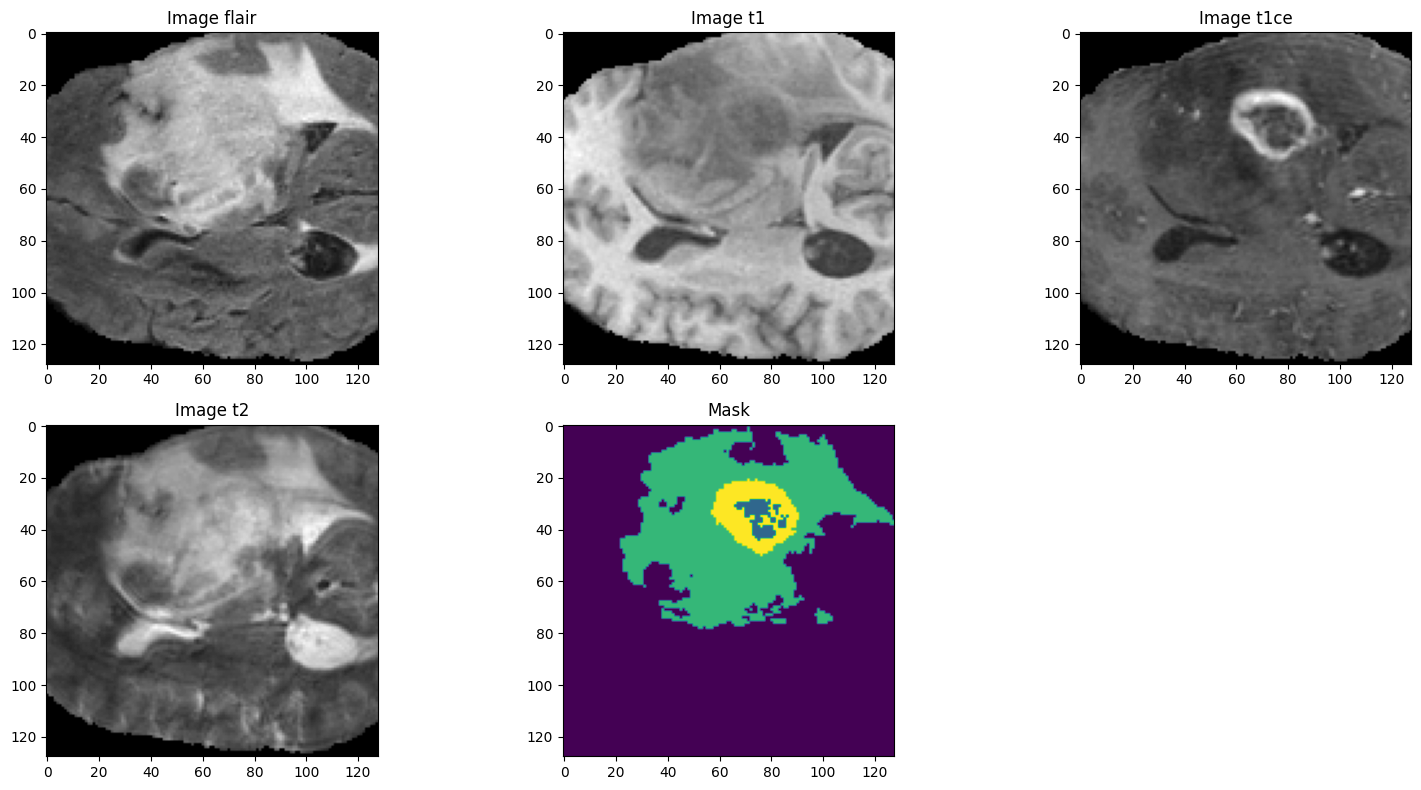

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Combine t1, t1ce, t2, and flair into a single multichannel image
combined_x = np.stack([test_image_flair, test_image_t1, test_image_t1ce, test_image_t2], axis=3)

# Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches.
# Cropping x, y, and z
combined_x = combined_x[56:184, 56:184, 13:141]  # Crop to 128x128x128x4 (length x width x slice x channel)

# Do the same for mask
test_mask = test_mask[56:184, 56:184, 13:141]
# here number of slices goes from 155 to 128 so do keep in mind that the input given above and 
# if u gave the same slice number here wont bring out the same slice as the indexing would've changed
# we sliced out slices from start and end as those images have no useful data as they are not there or very diminished.

n_slice = int(input("Enter Slice number to view (0-128) : "))
plt.figure(figsize=(16, 8))

plt.subplot(231)
plt.imshow(combined_x[:, :, n_slice, 0], cmap='gray')
plt.title('Image flair')

plt.subplot(232)
plt.imshow(combined_x[:, :, n_slice, 1], cmap='gray')
plt.title('Image t1')

plt.subplot(233)
plt.imshow(combined_x[:, :, n_slice, 2], cmap='gray')
plt.title('Image t1ce')

plt.subplot(234)
plt.imshow(combined_x[:, :, n_slice, 3], cmap='gray')
plt.title('Image t2')

plt.subplot(235)
plt.imshow(test_mask[:, :, n_slice])
plt.title('Mask')

plt.tight_layout()
plt.show()


<p style="font-size: 25px;">Applying Processing To Whole Dataset</p>

In [7]:
# Applying above modification on whole dataset and creating Train,Val and Test.
t1_list = sorted(glob.glob('C:/Users/abul4/OneDrive/Desktop/Project/MICCAI_BraTS2020_TrainingData/*/*t1.nii'))
t2_list = sorted(glob.glob('C:/Users/abul4/OneDrive/Desktop/Project/MICCAI_BraTS2020_TrainingData/*/*t2.nii'))
t1ce_list = sorted(glob.glob('C:/Users/abul4/OneDrive/Desktop/Project/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
flair_list = sorted(glob.glob('C:/Users/abul4/OneDrive/Desktop/Project/MICCAI_BraTS2020_TrainingData/*/*flair.nii'))
mask_list = sorted(glob.glob('C:/Users/abul4/OneDrive/Desktop/Project/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))
#Each volume generates 18 64x64x64x4 sub-volumes. 
#Total 369 volumes = 6642 sub volumes
useful=0
useless=0
for img in range(len(t2_list)):   
    print("Now preparing image and masks number: ", img)
    temp_image_t1=nib.load(t1_list[img]).get_fdata()
    temp_image_t1=scaler.fit_transform(temp_image_t1.reshape(-1,temp_image_t1.shape[-1])).reshape(temp_image_t1.shape)
      
    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3
    
    temp_combined_images = np.stack([temp_image_flair,temp_image_t1, temp_image_t1ce, temp_image_t2], axis=3)
    #cropping image and mask [ len,width,slice]
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141] #128x128x128
    temp_mask = temp_mask[56:184, 56:184, 13:141]                     #128x128x128
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
        print("Save Me")
        useful+=1
        temp_mask= to_categorical(temp_mask, num_classes=4)
        np.save('C:/Users/abul4/OneDrive/Desktop/Project/BraTS-2020 Stacked/image/image_'+str(img)+'.npy', temp_combined_images)
        np.save('C:/Users/abul4/OneDrive/Desktop/Project/BraTS-2020 Stacked/mask/mask_'+str(img)+'.npy', temp_mask)
    else:
        print("I am useless")   
        useless+=1
print("Total combined images : ")
print(len(temp_combined_images))
print("Total Number of Useful Images saved : ",useful)
print("Number of Useless images discarded : ",useless)


Now preparing image and masks number:  0
Save Me
Now preparing image and masks number:  1
Save Me
Now preparing image and masks number:  2
Save Me
Now preparing image and masks number:  3
Save Me
Now preparing image and masks number:  4
I am useless
Now preparing image and masks number:  5
Save Me
Now preparing image and masks number:  6
Save Me
Now preparing image and masks number:  7
Save Me
Now preparing image and masks number:  8
Save Me
Now preparing image and masks number:  9
Save Me
Now preparing image and masks number:  10
Save Me
Now preparing image and masks number:  11
Save Me
Now preparing image and masks number:  12
Save Me
Now preparing image and masks number:  13
Save Me
Now preparing image and masks number:  14
Save Me
Now preparing image and masks number:  15
Save Me
Now preparing image and masks number:  16
Save Me
Now preparing image and masks number:  17
Save Me
Now preparing image and masks number:  18
Save Me
Now preparing image and masks number:  19
Save Me
Now p

In [8]:
import splitfolders  # or import split_folders

input_folder = r'C:\Users\abul4\OneDrive\Desktop\Project\BraTS-2020 Stacked\\'
output_folder = r'C:\Users\abul4\OneDrive\Desktop\Project\BraTS-2020 Final\\'
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .20,.05), group_prefix=None) 
########################################

Copying files: 688 files [02:30,  4.58 files/s]
